In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [3]:
fig_path = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [4]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()


Vtransform=2
CPU times: user 6.79 s, sys: 3.89 s, total: 10.7 s
Wall time: 8.22 s


In [5]:
%%time

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] 

ds.close()


CPU times: user 4.33 s, sys: 1.63 s, total: 5.96 s
Wall time: 3.98 s


In [6]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_11-20yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=8, two=0) # 5-days mean
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 50.3 ms, sys: 14.6 ms, total: 64.9 ms
Wall time: 61.9 ms


In [7]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
dt = 5*86400 # 5-days in seconds
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 560, 630, 73)
(31, 560, 630, 73)
(73, 31, 560, 630)
CPU times: user 87.2 ms, sys: 73.6 ms, total: 161 ms
Wall time: 158 ms


### calculate dT/dt following old method to compare with new one:

In [8]:
%%time
# load ROMS avg output
for mm  in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    ds = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_his_00' + mm + '.nc')
    print(ds.variables["temp"].shape)
    ##- preserving 5-days avgs
    temp_tmp = ds.variables["temp"] # X,31,560,630

    # concatanate monthly avgs into a yearly variable
    if mm == '01':
        temp_snap2 = temp_tmp # 31,560,630
    else:
        temp_snap2 = np.concatenate((temp_snap2,temp_tmp), axis=0) # 2,31,560,630
    ds.close()
print(temp_snap2.shape)


dT2 = np.empty(temp_snap2.shape)
# loop to calculate difference:
for tt in np.arange(0,tlen):
    if tt == 0:
        dT2[tt,:] = temp_snap2[tt,:] - temp_ini
    else:
        dT2[tt,:] = temp_snap2[tt,:] - temp_snap2[tt-1,:]

temp_Rate2 = np.divide(dT2, dt)
# del dT2

(7, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(73, 31, 560, 630)
CPU times: user 7.38 s, sys: 11 s, total: 18.4 s
Wall time: 18.4 s


In [9]:
# load ROMS avg output
for mm  in ['01','02','03','04','05','06','07','08','09','10','11','12']:
    ds = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00' + mm + '.nc')
    print(ds.variables["temp"].shape)
    shflux_tmp = ds.variables["shflux"] # X,560,630

    # concatanate monthly avgs into a yearly variable
    if mm == '01':
        shflux2 = shflux_tmp
    else:
        shflux2 = np.concatenate((shflux2,shflux_tmp), axis=0)
    ds.close()


(7, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)
(6, 31, 560, 630)


In [10]:
# calculate surface sigma_theta (potential density)
sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000

# load ice draft to create masks
di = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

In [11]:
%%time
# method 2 to calculate Dz:
# z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.

Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
print(z_w.shape, Z_w.shape)
dz = np.diff(Z_w,axis=1)


(73, 560, 630, 32) (73, 32, 560, 630)
CPU times: user 17.6 s, sys: 15.8 s, total: 33.5 s
Wall time: 10.9 s


In [12]:
# this mask needs to be replaced by mask_shelf2 that uses the 1500-m contour

mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))

In [13]:
# # outdir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
# outdir = '/home/581/fbd581/cross_contour_tmp/'

# ds = xr.open_dataset(outdir + 'WAOM10extend_cross-1500m_vars4OHB.nc')
# mask_shelf = ds.Mask_shelf2
# ds.close()

In [14]:
mask_shelf

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [15]:
# mask of the coast 
mask_coast = ma.masked_where(np.isnan(temp_Rate2[0,-1,:,:]), np.ones(temp_Rate2[0,-1,:,:].shape))


In [16]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

In [17]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure:

# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    ###shflux_area = shflux[mm,:]*area*mask_shelf*mask_coast
    # needs xarray masking:
    shflux_area = shflux[mm,:].where(h < 1500)*area*mask_shelf
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    # del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:].where(h < 1500)*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vol[mm,:] = temp_rate_vint*area*mask_shelf#*mask_coast
    del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 1min 11s, sys: 1min 4s, total: 2min 15s
Wall time: 1min 40s


In [18]:
%%time

# 3. surface heat flux
shflux2_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux2_area = shflux2[mm,:]*area*mask_shelf*mask_coast
    shflux2_int[mm] = np.nansum(np.nansum(shflux2_area,axis=1), axis=0)
    del shflux2_area

# 4. volume-integral heat tendency using old temp_Rate2:
temp_rate2_int = np.empty((tlen))
temp_rate2_vol = np.empty(np.squeeze(temp_Rate2[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate2_dz = temp_Rate2[mm,:]*dz[mm,:]
    temp_rate2_vint = np.nansum(temp_rate2_dz, axis=0)
    temp_rate2_vol[mm,:] = temp_rate2_vint*area*mask_shelf
    del temp_rate2_vint
    temp_rate2_int[mm] = np.nansum(np.nansum(temp_rate2_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 4.8 s, sys: 2.92 s, total: 7.72 s
Wall time: 7.72 s


Text(0, 0.5, 'W.m$^{-2}$')

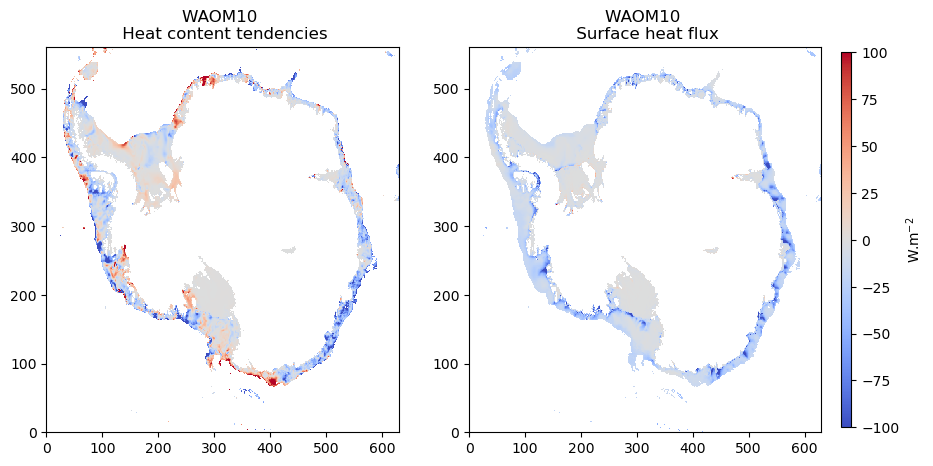

In [37]:
     
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10,5))

ax[0].title.set_text('WAOM10 \n Heat content tendencies')
# aa=ax[0,0].pcolormesh(np.nanmean(temp_rate_vol, axis=0)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
aa=ax[0].pcolormesh(np.divide(np.nanmean(temp_rate_vol[1:-1], axis=0),2.5)*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# plt.colorbar(aa)

ax[1].title.set_text('WAOM10 \n Surface heat flux')
bb=ax[1].pcolormesh(np.nanmean(shflux[1:-1], axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')

# cc=ax[1,0].pcolormesh(np.nanmean(temp_rate2_vol, axis=0)*mask_shelf, vmin=-100, vmax=100, cmap='coolwarm')

# dd=ax[1,1].pcolormesh(np.nanmean(shflux2, axis=0), vmin=-100, vmax=100, cmap='coolwarm')

# # diff maps:
# ee=ax[2,0].pcolormesh((np.nanmean(temp_rate_vol, axis=0))-(np.nanmean(temp_rate2_vol, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')

# ff=ax[2,1].pcolormesh((np.nanmean(shflux, axis=0))-(np.nanmean(shflux2, axis=0)), vmin=-100, vmax=100, cmap='coolwarm')


cax2 = plt.axes([0.92, 0.12, 0.01, 0.75])
cb = plt.colorbar(bb, cax=cax2, orientation='vertical')
cb.ax.set_ylabel('W.m$^{-2}$')

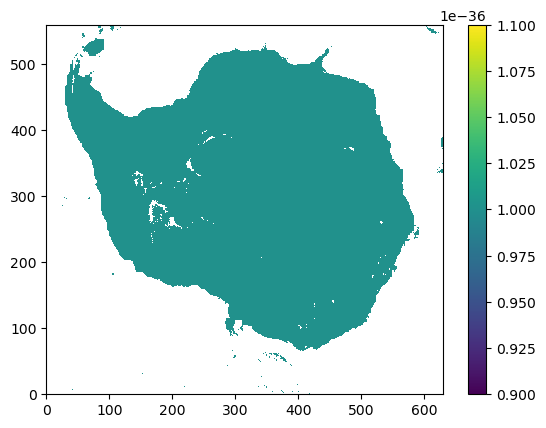

In [20]:
plt.pcolormesh(mask_shelf*1e-36)
plt.colorbar()

In [21]:
mask_shelf[100,100]

masked

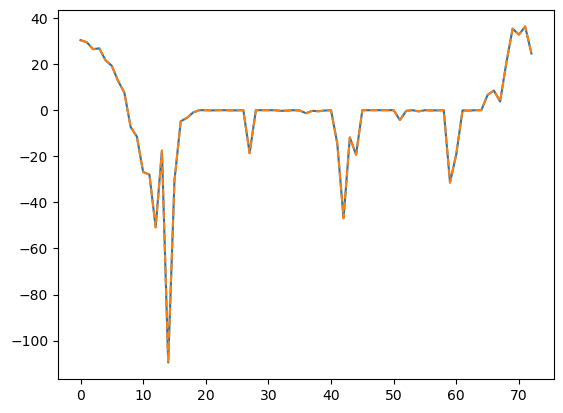

In [22]:
plt.plot(shflux[:,400,200])
plt.plot(shflux2[:,400,200],'--')

In [23]:
# mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))

shflux_mm7 = shflux.isel(ocean_time=7).where(h < 1500)

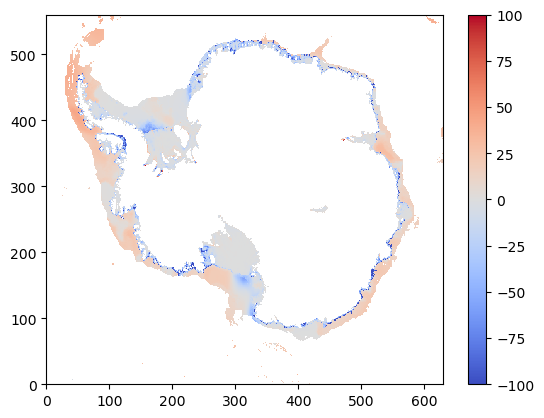

In [24]:
# plt.pcolormesh(shflux[7,:,:]*mask_shelf*mask_coast-shflux2[7,:,:]*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh((shflux[7,:,:]*area*mask_shelf*mask_coast)-(shflux2[7,:,:]*area*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')
plt.pcolormesh(shflux[7,:,:].where(h < 1500), vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh(shflux_mm7-(shflux2[7,:,:]*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh(shflux[7,:,:]-(shflux2[7,:,:]*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')
# plt.pcolormesh(shflux[7,:,:].where(h < 1500)-(shflux2[7,:,:]*mask_shelf*mask_coast), vmin=-100, vmax=100, cmap='coolwarm')

plt.colorbar()

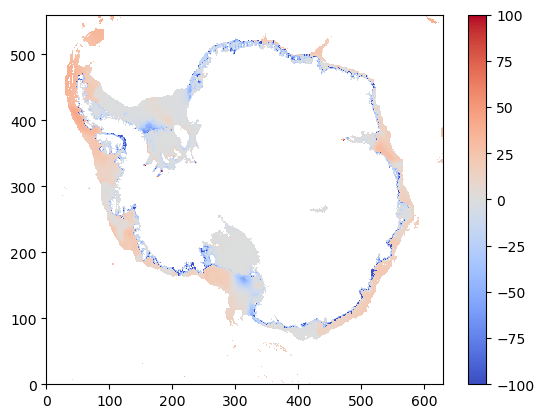

In [25]:
plt.pcolormesh(shflux2[7,:,:]*mask_shelf*mask_coast, vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


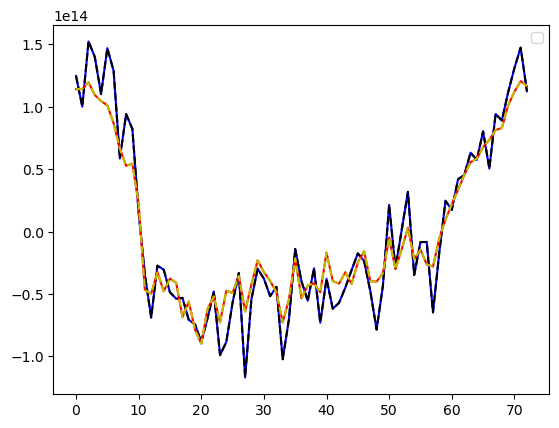

In [26]:
plt.plot(temp_rate_int-np.nanmean(temp_rate_int),'-b')
plt.plot(temp_rate2_int-np.nanmean(temp_rate2_int),'--k')
plt.plot(shflux_int-np.nanmean(shflux_int),'r')
plt.plot(shflux2_int-np.nanmean(shflux2_int),'--y')
plt.legend()


In [27]:
# OHB integrated
print(np.nanmean(temp_rate_int))#*1e-15)
print(np.nanmean(temp_rate2_int))#*1e-15)
print(np.nanmean(shflux_int))#*1e-15)



-747408591268.3589
-746657814185.3701
-69651703430089.09


Text(0.5, 1.0, 'WAOM10')

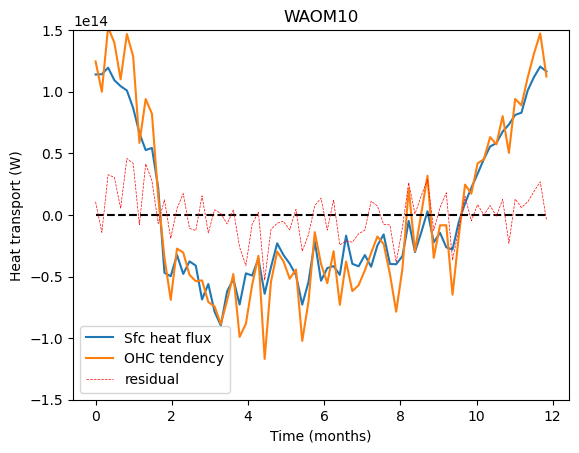

In [28]:
ohc_tend = temp_rate_int - np.nanmean(temp_rate_int)
ohc_tend2 = temp_rate2_int - np.nanmean(temp_rate2_int)
shflux_tend = shflux_int - np.nanmean(shflux_int)

months=np.arange(0,73)*(5/30.41667)

plt.plot(months,shflux_tend, label='Sfc heat flux')
plt.plot(months,ohc_tend, label='OHC tendency')
# plt.plot(months,ohc_tend2,'--', label='OHC tendency old')
plt.plot(months,shflux_int*0,'--k')
plt.plot(months,ohc_tend - shflux_tend, '--r', label='residual',linewidth=0.5)
plt.ylim([-1.5e14,1.5e14])

plt.legend()
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('WAOM10')